Quelle: https://www.kaggle.com/code/pratikskarnik/resnet-regressor

# Pawpularity Score: pretrained ResNet50 with "imagenet"

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import missingno as msno
from pathlib import Path
from tqdm import tqdm
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Import Data

In [2]:
# for dirname, _, filenames in os.walk('../input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
train=pd.read_csv('/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/Praktikum/input/train.csv') 
test=pd.read_csv('/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/Praktikum/input/test.csv')   

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold
import tensorflow as tf

In [4]:
train["file_path"] = train["Id"].apply(lambda x: "/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/Praktikum/input/train/" + x + ".jpg")
test["file_path"] = test["Id"].apply(lambda x: "/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/Praktikum/input/test/" + x + ".jpg")

In [5]:
train

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/P...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/P...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/P...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/P...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/P...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15,/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/P...
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70,/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/P...
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20,/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/P...
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20,/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/P...


## Preprocess Data

In [6]:
image_size = 128
def preprocess(image_url):
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (image_size, image_size))
    return image
x_train=[]
for i in train['file_path']:
    x1=preprocess(i)
    x_train.append(x1)

Metal device set to: Apple M1 Pro


2022-12-19 20:50:39.042882: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-19 20:50:39.043036: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
x_train[0]

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.4715907 , 0.45982596, 0.50296324],
        [0.41024145, 0.39847675, 0.441614  ],
        [0.4042202 , 0.3924555 , 0.43559274],
        ...,
        [0.70974016, 0.7188088 , 0.7597402 ],
        [0.7086278 , 0.7216594 , 0.75368035],
        [0.69903743, 0.71080214, 0.74119425]],

       [[0.70354825, 0.70305806, 0.7425188 ],
        [0.67488223, 0.67439204, 0.7138528 ],
        [0.65424615, 0.6537559 , 0.69321674],
        ...,
        [0.6296582 , 0.6511329 , 0.63554716],
        [0.658103  , 0.66492015, 0.6698677 ],
        [0.66543835, 0.6691148 , 0.67695796]],

       [[0.7464854 , 0.7582501 , 0.79354423],
        [0.73778826, 0.7495529 , 0.7848471 ],
        [0.75046927, 0.762234  , 0.7975281 ],
        ...,
        [0.58390504, 0.67900306, 0.51314795],
        [0.5856789 , 0.65895516, 0.508397  ],
        [0.60614103, 0.67550373, 0.51447433]],

       ...,

       [[0.5648438 , 0.56520563, 0.52609056],
        [0.54

In [8]:
test2=[]
for i in test['file_path']:
    x1=preprocess(i)
    test2.append(x1)
test2=np.array(test2)

In [9]:
X=np.array(x_train)
y=train['Pawpularity']
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=86)

## Load pretrained Model

In [10]:
def create_model(input_shape, top='flatten'):
    if top not in ('flatten', 'avg', 'max'):
        raise ValueError('unexpected top layer type: %s' % top)

    # connects base model with new "head"
    BottleneckLayer = {
        'flatten': keras.layers.Flatten(),
        'avg': keras.layers.GlobalAveragePooling2D(),
        'max': keras.layers.GlobalMaxPool2D()
    }[top]

    base = tf.keras.applications.resnet50.ResNet50(input_shape=input_shape,
                             include_top=False, 
                             weights='imagenet')
#tf.keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

    x = BottleneckLayer(base.output)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(1, activation='relu')(x)
    model = tf.keras.Model(inputs=base.inputs, outputs=x)
    return model
input_shape=(128,128,3)
model=create_model(input_shape)

94765736/94765736 [==============================] - 47s 0us/step


In [11]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_rmse',patience=10, verbose=1,mode='min',restore_best_weights=True
    )
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_rmse",
    factor=0.2,
    patience=3, 
    min_lr=1e-7,
    verbose=1,
    mode='min'
    )
callbacks = [early_stop,reduce_lr]

In [12]:
model.compile(loss='mse', optimizer='Adam', metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse"), "mae", "mape"])

In [13]:
#model.summary()

## Training

In [14]:
history = model.fit(x_train,y_train,epochs=50,batch_size=128,validation_data=(x_test,y_test),callbacks=callbacks)

Epoch 1/50


2022-12-19 20:54:35.898861: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-19 20:54:38.496191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 500.6302 - rmse: 22.3748 - mae: 16.7571 - mape: 80.7021

2022-12-19 20:55:32.003616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 60s 701ms/step - loss: 500.6302 - rmse: 22.3748 - mae: 16.7571 - mape: 80.7021 - val_loss: 937.4187 - val_rmse: 30.6173 - val_mae: 24.9273 - val_mape: 69.7243 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 42s 600ms/step - loss: 435.5217 - rmse: 20.8692 - mae: 15.7330 - mape: 78.6079 - val_loss: 408.3138 - val_rmse: 20.2068 - val_mae: 13.6523 - val_mape: 58.7116 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 42s 593ms/step - loss: 403.1821 - rmse: 20.0794 - mae: 15.0883 - mape: 75.5366 - val_loss: 404.7586 - val_rmse: 20.1186 - val_mae: 13.5962 - val_mape: 58.9456 - lr: 0.0010
Epoch 4/50
70/70 [==============================] - 42s 596ms/step - loss: 337.7234 - rmse: 18.3773 - mae: 13.8713 - mape: 69.0135 - val_loss: 344.4428 - val_rmse: 18.5592 - val_mae: 13.3941 - val_mape: 71.7597 - lr: 0.0010
Epoch 5/50
70/70 [==============================] - 42s 601ms/step - loss: 249.9959 - rmse: 15.8113 - mae: 11.9694 

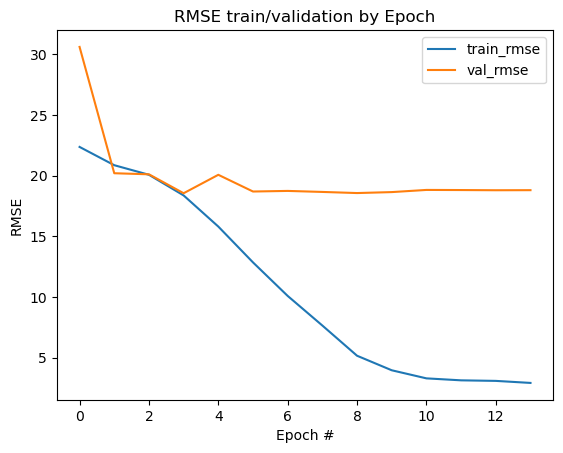

In [15]:
plt.figure()
plt.plot(history.history["rmse"], label="train_rmse")
plt.plot(history.history["val_rmse"], label="val_rmse")
#plt.xticks(range(0,60))
plt.title("RMSE train/validation by Epoch")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend(loc="upper right")

## Prediction

In [16]:
cnn_pred=model.predict(test2)

2022-12-19 21:04:42.015536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


In [17]:
cnn=pd.DataFrame()
cnn['Id']=test['Id']
cnn['Pawpularity']=cnn_pred
#cnn.to_csv('submission.csv',index=False)

In [18]:
cnn

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,35.519611
1,43a2262d7738e3d420d453815151079e,35.420876
2,4e429cead1848a298432a0acad014c9d,35.538521
3,80bc3ccafcc51b66303c2c263aa38486,35.574905
4,8f49844c382931444e68dffbe20228f4,35.490227
5,b03f7041962238a7c9d6537e22f9b017,35.540749
6,c978013571258ed6d4637f6e8cc9d6a3,35.456390
7,e0de453c1bffc20c22b072b34b54e50f,35.312542
